In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.externals import joblib
from random import randint
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import itertools

In [3]:
Housing_price=pd.read_csv('new.csv', sep=',', encoding='iso-8859-1', low_memory=False)

In [3]:
Housing_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318851 entries, 0 to 318850
Data columns (total 26 columns):
url                    318851 non-null object
id                     318851 non-null object
Lng                    318851 non-null float64
Lat                    318851 non-null float64
Cid                    318851 non-null int64
tradeTime              318851 non-null object
DOM                    160874 non-null float64
followers              318851 non-null int64
totalPrice             318851 non-null float64
price                  318851 non-null int64
square                 318851 non-null float64
livingRoom             318851 non-null object
drawingRoom            318851 non-null object
kitchen                318851 non-null int64
bathRoom               318851 non-null object
floor                  318851 non-null object
buildingType           316830 non-null float64
constructionTime       318851 non-null object
renovationCondition    318851 non-null int64
buildingStruct

# Data Exploration

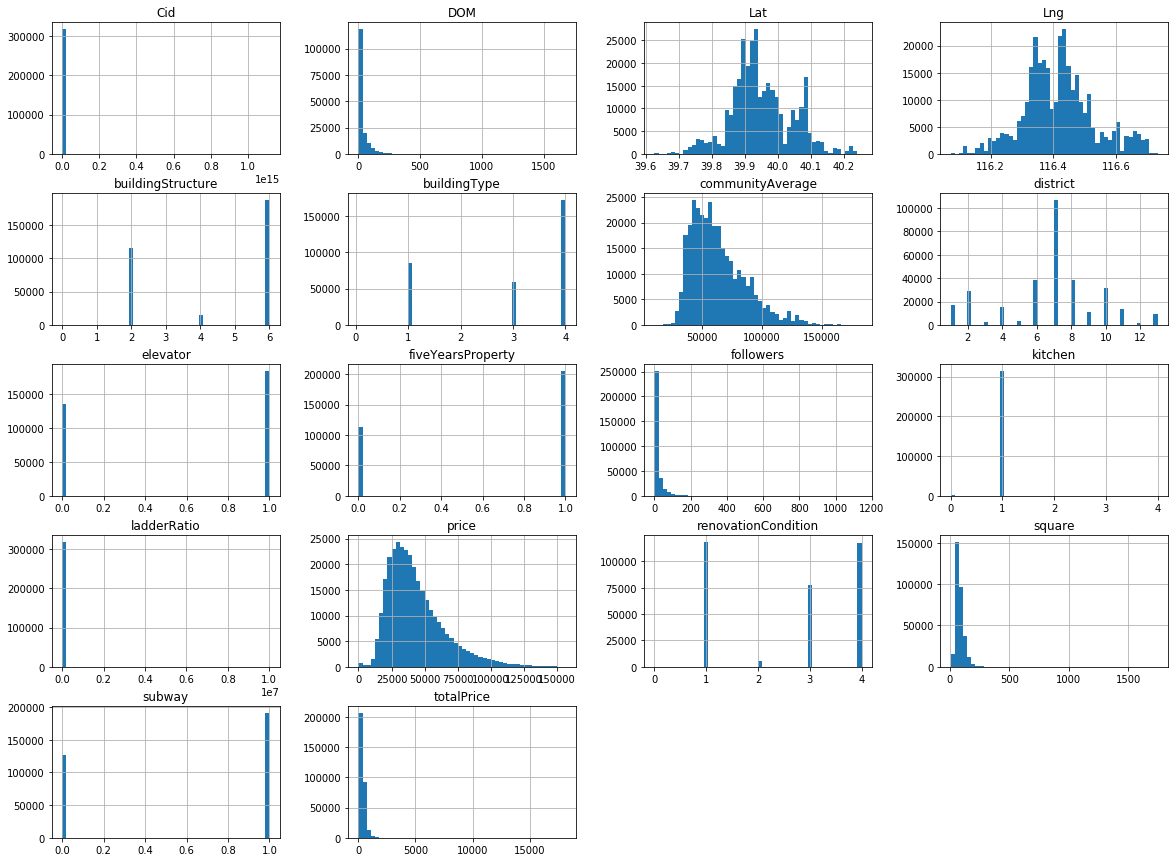

In [4]:
Housing_price.hist(bins=50, figsize=(20,15))
plt.show()

In [5]:
Housing_price.head()

,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,...,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
0,https://bj.lianjia.com/chengjiao/101084782030....,101084782030,116.475489,40.019520,1111027376244,2016-08-09,1464.0,106,415.0,31680,...,1.0,2005,3,6,0.217,1.0,0.0,1.0,7,56021.0
1,https://bj.lianjia.com/chengjiao/101086012217....,101086012217,116.453917,39.881534,1111027381879,2016-07-28,903.0,126,575.0,43436,...,1.0,2004,4,6,0.667,1.0,1.0,0.0,7,71539.0
2,https://bj.lianjia.com/chengjiao/101086041636....,101086041636,116.561978,39.877145,1111040862969,2016-12-11,1271.0,48,1030.0,52021,...,4.0,2005,3,6,0.500,1.0,0.0,0.0,7,48160.0
3,https://bj.lianjia.com/chengjiao/101086406841....,101086406841,116.438010,40.076114,1111043185817,2016-09-30,965.0,138,297.5,22202,...,1.0,2008,1,6,0.273,1.0,0.0,0.0,6,51238.0
4,https://bj.lianjia.com/chengjiao/101086920653....,101086920653,116.428392,39.886229,1111027381174,2016-08-28,927.0,286,392.0,48396,...,4.0,1960,2,2,0.333,0.0,1.0,1.0,1,62588.0


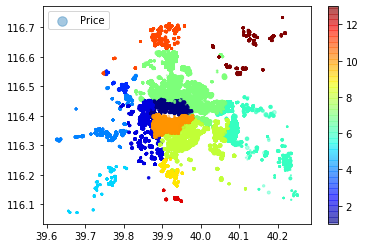

In [6]:
fig = plt.scatter(x=Housing_price['Lat'], y=Housing_price['Lng'], alpha=0.4, \
    s=Housing_price['totalPrice']/100, label='Price', \
    c=Housing_price['district'], cmap=plt.get_cmap('jet'))
plt.colorbar(fig)
plt.legend()
plt.show()

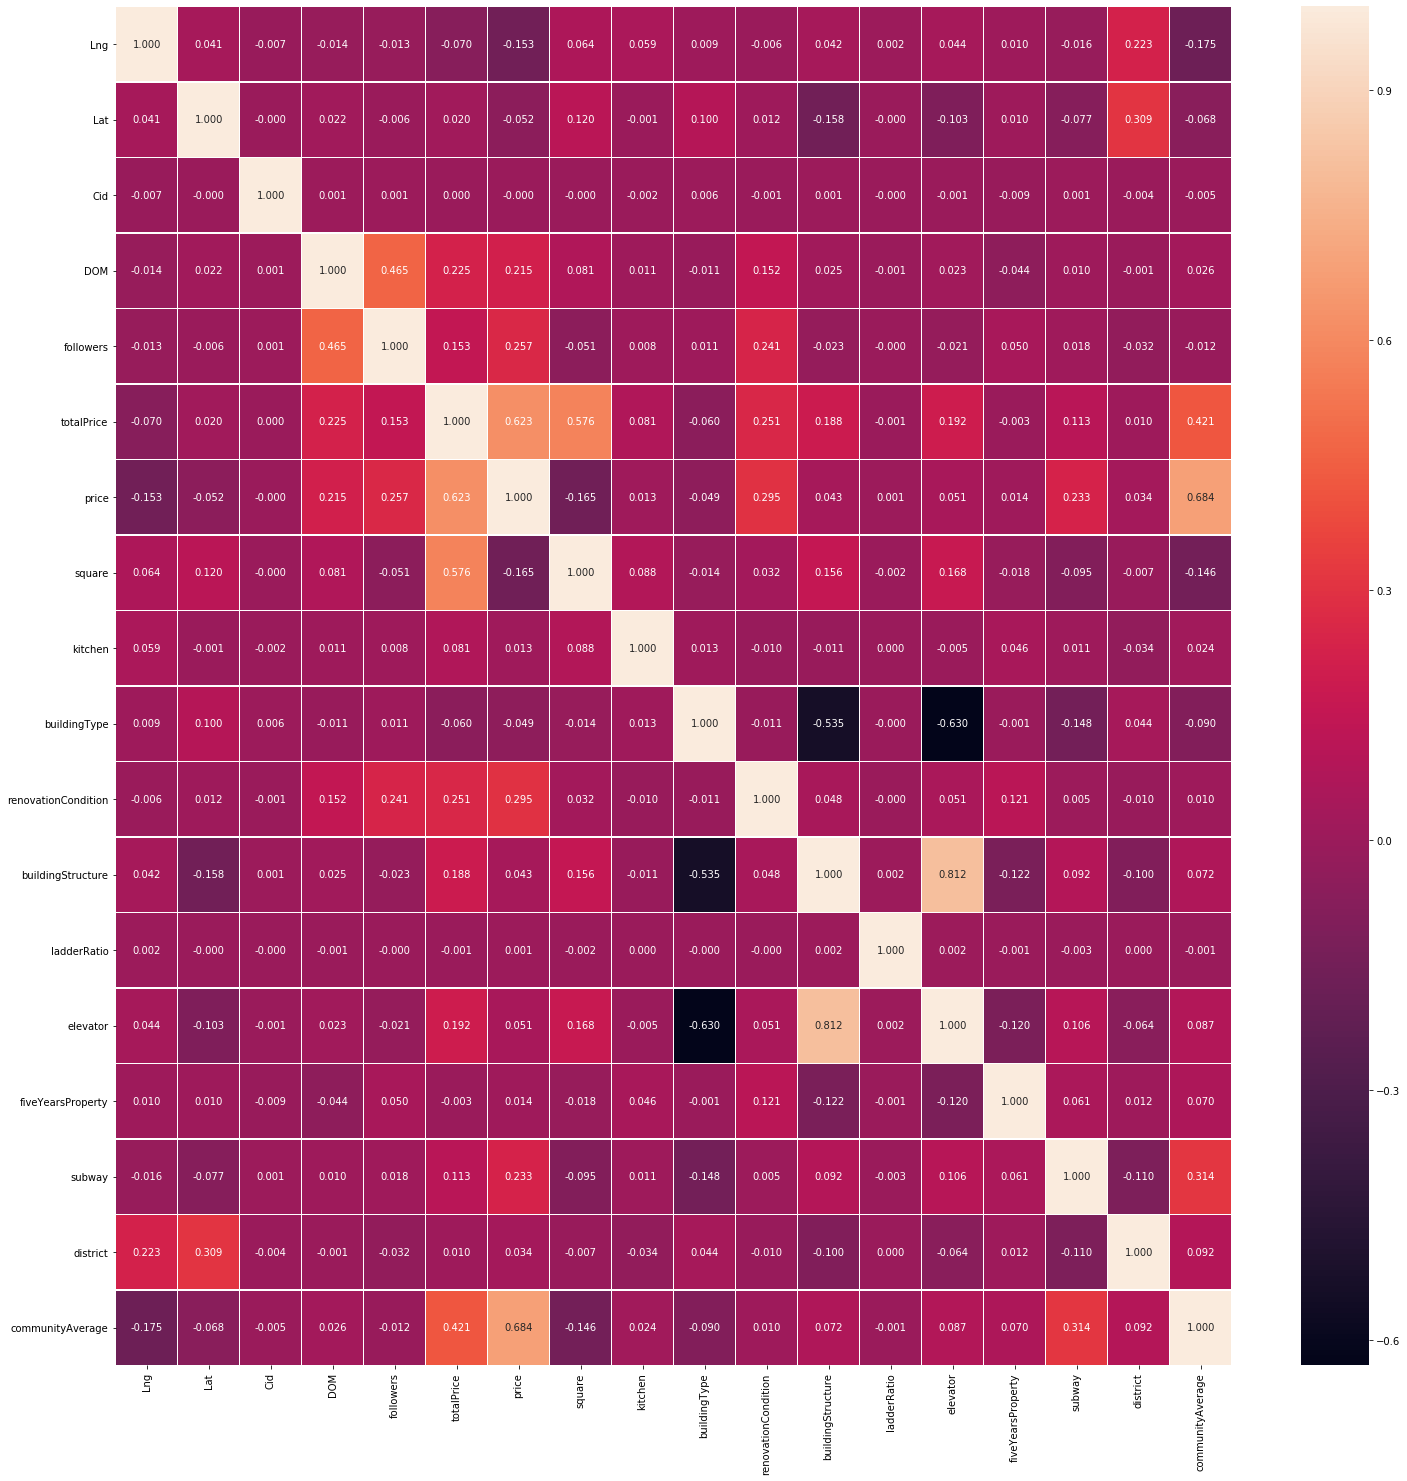

In [7]:
f,ax = plt.subplots(figsize=(25, 25))
sns.heatmap(Housing_price.corr(), annot = True, linewidth = .5, fmt = ".3f",ax = ax)
plt.show()

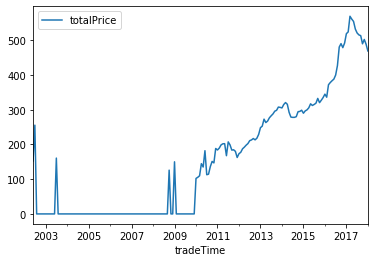

In [8]:
price_by_trade_time = pd.DataFrame()
price_by_trade_time['totalPrice'] = Housing_price['totalPrice']
price_by_trade_time.index = Housing_price['tradeTime'].astype('datetime64[ns]')
price_by_trade_month = price_by_trade_time.resample('M').mean().to_period('M').fillna(0)
price_by_trade_month.plot(kind='line')
plt.show()

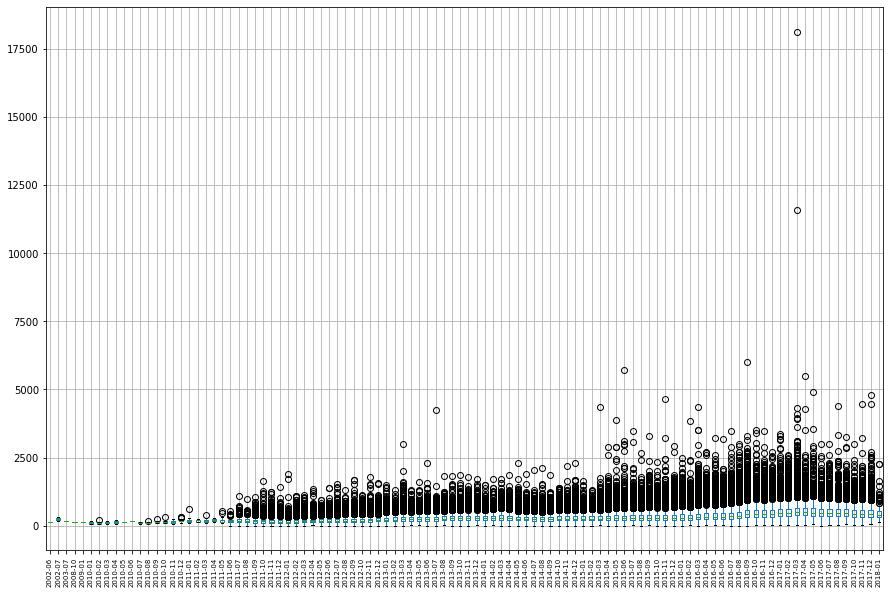

In [9]:
price_stat_trade_month_index = [x.strftime('%Y-%m') for x in set(price_by_trade_time.to_period('M').index)]
price_stat_trade_month_index.sort()
price_stat_trade_month = []
for month in price_stat_trade_month_index:
    price_stat_trade_month.append(price_by_trade_time[month]['totalPrice'].values)
price_stat_trade_month = pd.DataFrame(price_stat_trade_month)
price_stat_trade_month.index = price_stat_trade_month_index
price_stat_trade_month = price_stat_trade_month.T
price_stat_trade_month.boxplot(figsize=(15,10))
plt.xticks(rotation=90,fontsize=7)
plt.show()

# Prediction Housing Price

In [4]:
housing=Housing_price
housing = housing.drop(['url','id','totalPrice','Cid','DOM','tradeTime', 'floor', 'followers', 'communityAverage'], axis=1)
housing.head()

,Lng,Lat,price,square,livingRoom,drawingRoom,kitchen,bathRoom,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district
0,116.475489,40.019520,31680,131.00,2,1,1,1,1.0,2005,3,6,0.217,1.0,0.0,1.0,7
1,116.453917,39.881534,43436,132.38,2,2,1,2,1.0,2004,4,6,0.667,1.0,1.0,0.0,7
2,116.561978,39.877145,52021,198.00,3,2,1,3,4.0,2005,3,6,0.500,1.0,0.0,0.0,7
3,116.438010,40.076114,22202,134.00,3,1,1,1,1.0,2008,1,6,0.273,1.0,0.0,0.0,6
4,116.428392,39.886229,48396,81.00,2,1,1,1,4.0,1960,2,2,0.333,0.0,1.0,1.0,1


# Making traing and testing data set

In [5]:
spliter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in spliter.split(housing, housing['district']):
    train_set = housing.loc[train_index]
    test_set = housing.loc[test_index]

housing = train_set.copy()

In [6]:
class DataNumCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, clean=True):
        self.clean = clean
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.clean:
            X = X[(X.constructionTime != '0') & (X.constructionTime != '1') & (X.constructionTime !=  'Î´Öª')]
            X['constructionTime'] = 2018 - X['constructionTime'].astype('int64')
            X = X[(X.buildingType == 1) | (X.buildingType == 2) | (X.buildingType == 3) | (X.buildingType == 4)]
            X = X[X.livingRoom != '#NAME?']
            X = X[(X.drawingRoom == '0') | (X.drawingRoom == '1') | (X.drawingRoom == '2') | (X.drawingRoom == '3') | (X.drawingRoom == '4') | (X.drawingRoom == '5')]
            X = X[(X.bathRoom == '0') | (X.bathRoom == '1') | (X.bathRoom == '2') | (X.bathRoom == '3') | (X.bathRoom == '4') | (X.bathRoom == '5') | (X.bathRoom == '6') | (X.bathRoom == '7')]
            X.bathRoom = X.bathRoom.astype('float64')
            X.drawingRoom = X.drawingRoom.astype('float64')
            X.livingRoom = X.livingRoom.astype('float64')
            return X
        else:
            return X

In [7]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    """docstring for DataFrameSelector"""
    def __init__(self, attribute_name):
        self.attribute_name = attribute_name
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_name].values

In [8]:
def display_scores(scores):
    print('Scores: ', scores)
    print('Mean: ', scores.mean())
    print('Standard deviation: ', scores.std())



In [9]:
num_attributes = ['Lng', 'Lat', 'square', 'livingRoom', 'drawingRoom', 'kitchen', 'bathRoom', 'constructionTime',  'ladderRatio', 'elevator', 'fiveYearsProperty', 'subway']
cat_attributes = ['buildingType', 'renovationCondition', 'buildingStructure', 'district']

num_pipeline = Pipeline([
    ('cleaner', DataNumCleaner()),
    ('selector', DataFrameSelector(num_attributes)),
    ('imputer', Imputer(strategy='most_frequent')),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('cleaner', DataNumCleaner()),
    ('selector', DataFrameSelector(cat_attributes)),
    ('encoder', OneHotEncoder())
])

label_pipeline = Pipeline([
    ('cleaner', DataNumCleaner()),
    ('selector', DataFrameSelector(['price']))
])

full_pipeline = FeatureUnion([
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

/Users/xurui1993/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [10]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_label = label_pipeline.fit_transform(housing)

/Users/xurui1993/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/xurui1993/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/xurui1993/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(valu

# Model 1: LinearSVR

In [11]:
lin_svm_reg = LinearSVR()
lin_svm_reg_scores = cross_val_score(lin_svm_reg, housing_prepared, housing_label, scoring='neg_mean_squared_error', cv=10)
lin_svm_reg_rmse_scores = np.sqrt(-lin_svm_reg_scores)
display_scores(lin_svm_reg_rmse_scores)

/Users/xurui1993/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xurui1993/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xurui1993/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xurui1993/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

Scores:  [18392.15308935 18467.41618678 18671.27660455 18589.17820633
 18723.90407126 18559.05227795 18463.03494997 18719.71271087
 18678.16835524 18748.52493335]
Mean:  18601.24213856353
Standard deviation:  120.10423921096762


In [12]:
lin_svm_reg = LinearSVR(C=0.5,loss='squared_epsilon_insensitive')
lin_svm_reg.fit(housing_prepared,housing_label)

/Users/xurui1993/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearSVR(C=0.5, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='squared_epsilon_insensitive',
          max_iter=1000, random_state=None, tol=0.0001, verbose=0)

In [13]:
X_test_prepared = full_pipeline.fit_transform(test_set)
y_test = label_pipeline.fit_transform(test_set)
final_predictons = lin_svm_reg.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictons)

/Users/xurui1993/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/xurui1993/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/xurui1993/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(valu

[array([71695.89439965]), array([51141.57350176]), array([16483.08187909]), array([20465.59441326]), array([19750.85199893]), array([42601.84762344]), array([45435.72312597]), array([39865.25472758]), array([25603.24841193]), array([23971.39789764]), array([34104.62888891]), array([46003.81746674]), array([37320.1477772]), array([33223.62349319]), array([27445.59685993]), array([32174.28537578]), array([67445.77780799]), array([45922.47714309]), array([49710.63417595]), array([41736.40314332]), array([50243.42296413]), array([37206.51501446]), array([42015.90116867]), array([31337.93065111]), array([33594.29174261]), array([31443.02254582]), array([46631.9838201]), array([55607.71257818]), array([28996.04485761]), array([40644.37781448]), array([19354.13116004]), array([44602.49163349]), array([45377.11451071]), array([22668.87355629]), array([15462.78341494]), array([57140.24839611]), array([32437.78119732]), array([51162.79171828]), array([42597.34861034]), array([42081.02446279]), a

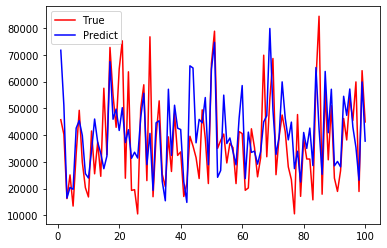

In [14]:
test_index = [randint(0,len(y_test)) for i in range(100)]
y_label = [y_test[index] for index in test_index]
y_predict = [lin_svm_reg.predict(X_test_prepared[index]) for index in test_index]
print(y_predict)
x = [i+1 for i in range(100)]
plt.plot(x, y_label, c='red', label='True')
plt.plot(x, y_predict, c='blue', label='Predict')
plt.legend()
plt.show()

# Model 2: Linear Regression

In [14]:
regressor=LinearRegression()
  
# fit the regressor with x and y data 
regressor.fit(housing_prepared,housing_label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [57]:
test_index = [randint(0,len(y_test)) for i in range(100)]
y_label = [y_test[index] for index in test_index]
y_predict2 = [regressor.predict(X_test_prepared[index]) for index in test_index]
print(y_predict2)

[array([[51384.31665039]]), array([[39080.3769491]]), array([[26755.20377471]]), array([[34599.89786247]]), array([[48667.88751203]]), array([[45626.45813336]]), array([[34182.18527326]]), array([[51861.05780678]]), array([[26834.61433127]]), array([[76302.82228342]]), array([[41587.23471765]]), array([[68595.83765684]]), array([[32236.97564302]]), array([[33461.48628363]]), array([[50993.19437261]]), array([[54919.75791021]]), array([[33367.36483353]]), array([[72511.88630801]]), array([[27540.85880927]]), array([[45583.60360395]]), array([[32725.93263246]]), array([[51416.24722548]]), array([[32059.21946555]]), array([[29589.47635446]]), array([[60019.52012242]]), array([[34747.60635282]]), array([[77914.81399411]]), array([[70120.14686645]]), array([[46652.84030938]]), array([[41584.15478317]]), array([[60914.84570842]]), array([[31118.94460175]]), array([[42915.32863334]]), array([[68020.04979441]]), array([[34380.62776803]]), array([[36414.56825482]]), array([[74187.45534284]]), a

In [59]:
y_predict2=[[51384.31665039], [39080.3769491], [26755.20377471], [34599.89786247], [48667.88751203], [45626.45813336], [34182.18527326], [51861.05780678],  [26834.61433127], [76302.82228342], [41587.23471765],  [68595.83765684],  [32236.97564302],  [33461.48628363],  [50993.19437261],  [54919.75791021],  [33367.36483353],  [72511.88630801],  [27540.85880927],  [45583.60360395],  [32725.93263246],  [51416.24722548],  [32059.21946555],  [29589.47635446],  [60019.52012242],  [34747.60635282],  [77914.81399411],  [70120.14686645], [46652.84030938],  [41584.15478317], [60914.84570842], [31118.94460175], [42915.32863334], [68020.04979441],  [34380.62776803],  [36414.56825482], [74187.45534284], [67795.46891887],  [43176.4148972], [33573.28402554], [23650.54990196], [51916.92376512], [54424.48010843],  [31107.70180201],  [80142.66896756],  [32765.03560422],  [44208.36297203] , [28574.49230103], [38964.49983457], [30581.80247384], [47159.37008354], [43095.67952412], [17987.8067556], [20711.00468695], [50246.46295256], [57856.77420672], [30623.24909691], [68178.63712428],  [36313.54521991], [38895.51743203], [38654.28715054], [29319.80410552], [30289.32553793], [50406.65018501], [52728.34380585], [75729.38442281], [36642.55305493],  [46064.31905116], [24535.98347567], [22151.86363662], [56080.14236156],  [37647.72296325],  [41844.13516425],  [62273.275724] ,  [71918.03195055],  [45498.56055985],  [74497.88966688],  [55549.53797385], [43328.46722259], [17611.32315654], [72344.67990701],  [47256.35505285], [39844.38214712], [66173.96308316], [45908.56053708], [68874.0684764], [41001.74296849], [69854.72852708], [36766.9808423],  [57960.123323],  [29792.5142522],  [74177.91148355], [73100.45657422],  [28966.97028229], [45214.58354072], [29915.54984575],  [40283.87243747], [57029.42777716],  [36526.13383466],  [34630.07285894]]

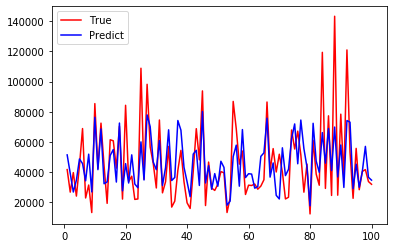

In [60]:

x = [i+1 for i in range(100)]
plt.plot(x, y_label, c='red', label='True')
plt.plot(x, y_predict2, c='blue', label='Predict')
plt.legend()
plt.show()

# Model 3: Gaussian Process Regression

In [13]:
import sklearn.gaussian_process as gp

In [14]:
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))

In [15]:
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)

In [ ]:
housing_prepared=housing_prepared.toarray()
model.fit(housing_prepared, housing_label)
params = model.kernel_.get_params()

In [ ]:
test_index = [randint(0,len(y_test)) for i in range(100)]
y_label = [y_test[index] for index in test_index]
y_predict2 = [model.predict(X_test_prepared[index]) for index in test_index]

# Model 4: SVR

In [15]:
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})


In [17]:
housing_label=housing_label.ravel()

In [ ]:
svr.fit(housing_prepared, housing_label)

In [ ]:
test_index = [randint(0,len(y_test)) for i in range(100)]
y_label = [y_test[index] for index in test_index]
y_predict = [svr.predict(X_test_prepared[index]) for index in test_index]
print(y_predict)
x = [i+1 for i in range(100)]
plt.plot(x, y_label, c='red', label='True')
plt.plot(x, y_predict, c='blue', label='Predict')
plt.legend()
plt.show()